In [2]:
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from scipy.stats import poisson

In [3]:
# get data
API_KEY = os.getenv("API_KEY")
url = 'https://data-service.beatthebookie.blog/data'
headers = {"x-api-key": API_KEY}

# Function to fetch data for a specific division and season
def fetch_data(division, season):
    params = {
        'division': division,
        'season': season
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.read_json(io.StringIO(response.content.decode('utf-8')))
    else:
        print(f"Error fetching {division} {season}: {response.status_code}")
        print(response.content.decode('utf-8'))
        return pd.DataFrame()

# Fetch data for all combinations
seasons = ['2024_2025', '2023_2024']
divisions = ['Premier League', 'Championship']
dataframes = []

for division in divisions:
    for season in seasons:
        df = fetch_data(division, season)
        if not df.empty:
            dataframes.append(df)

# Combine all dataframes
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    
    # Convert match_date to datetime
    df['match_date'] = pd.to_datetime(df['match_date'])

df

,division_id,division,season_id,season,match_date,match_teams,home_team_id,home_team,away_team_id,away_team,...,away_xgoals,home_deep,away_deep,home_ppda,away_ppda,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds
0,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-16,Man United - Fulham,f2b82cdbdadf9d3ec47c3a6be66dcfad,Man United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,0.418711,7.0,3.0,7.379310,10.833333,1.60,4.20,5.25,2.50,1.53
1,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Everton - Brighton,6414a61d98ab23b6d757e888ab17a66a,Everton,0d84883ca72c88cb53c8a38262efdcbc,Brighton,...,1.790830,4.0,5.0,18.333333,7.916667,2.63,3.30,2.63,2.00,1.80
2,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Ipswich - Liverpool,e4f63bf6d6d2cd121e6c8e59bef68209,Ipswich,afce84ff226407a47c9782a742ba02f7,Liverpool,...,3.929060,2.0,13.0,18.777778,8.739130,8.50,5.50,1.33,3.00,1.40
3,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Nott'm Forest - Bournemouth,9a8e1e9fad8766fc3d69a0c26d98b928,Nott'm Forest,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,...,1.909150,10.0,4.0,8.653846,9.954545,2.45,3.50,2.80,2.10,1.73
4,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Newcastle - Southampton,78e9266876e7649e0a12e3840f5be006,Newcastle,5a884401673693b0bdf379fefb7ec2b2,Southampton,...,1.954830,4.0,13.0,16.250000,3.789474,1.36,5.25,8.00,3.00,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Sunderland - Sheffield Weds,1820e986a8a213df782c5cf5ad0b65e1,Sunderland,ec5c8ee83966ae3a295abeee6ab46871,Sheffield Weds,...,1.300000,NaN,NaN,NaN,NaN,2.70,3.40,2.55,1.80,2.00
1653,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Rotherham - Cardiff,095ea4179483dfdd7fd4ee61a25954f4,Rotherham,288a6430a6f57a76e823d74e0dd750d2,Cardiff,...,1.300000,NaN,NaN,NaN,NaN,3.40,3.40,2.20,1.73,2.10
1654,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Leicester - Blackburn,a06360acafe964d244e424cbd50862e8,Leicester,8178de69a5e17f7bbe3a74331977feb1,Blackburn,...,1.700000,NaN,NaN,NaN,NaN,1.70,3.75,5.25,2.50,1.53
1655,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Plymouth Argyle - Hull,a0111c6b8f3812f2e36ababf2c032d8c,Plymouth Argyle,63b0fc998685327831f96bbe7b07b7e2,Hull,...,0.500000,NaN,NaN,NaN,NaN,3.50,3.75,2.00,2.30,1.62


In [4]:
# Separates out the home vs away and allows every team to have an individual row of data. Allows us to feature engineer home effect easier.
home_df = df[["division", "season", "match_date",
             "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals",  "home_deep", "home_ppda", "home_red",
             "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals", "away_deep", "away_ppda", "away_red",
              "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds"]].copy()
home_df["home?"] = 1
home_df = home_df.rename(columns={"home_team":"team", "home_avg_market_value":"avg_market_value", "home_goals":"goals",
             "home_shots":"shots", "home_xgoals":"xG",  "home_deep":"deep", "home_ppda":"ppda", "home_red": "red",
             "away_team":"opponent_team", "away_avg_market_value":"opponent_avg_market_value", "away_goals":"opponent_goals", 
             "away_shots": "opponent_shots", "away_xgoals": "opponent_xG", "away_deep":"opponent_deep", "away_ppda":"opponent_ppda", "away_red": "opponent_red"})

away_df = df[["division", "season", "match_date",
                "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals",  "away_deep", "away_ppda", "away_red",
                "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals", "home_deep", "home_ppda", "home_red",
                 "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds"]].copy()
away_df["home?"] = 0
away_df = away_df.rename(columns={"away_team":"team", "away_avg_market_value":"avg_market_value", "away_goals":"goals",
             "away_shots":"shots", "away_xgoals":"xG", "away_deep":"deep", "away_ppda":"ppda", "away_red": "red",
             "home_team":"opponent_team", "home_avg_market_value":"opponent_avg_market_value", "home_goals":"opponent_goals", 
             "home_shots": "opponent_shots", "home_xgoals": "opponent_xG", "home_deep":"opponent_deep", "home_ppda":"opponent_ppda", "home_red": "opponent_red"})

df = pd.concat([away_df, home_df])
df["prem?"] = df["division"].apply(lambda x: 1 if x == "Premier League" else 0)
df.sort_values(["match_date", "division"], inplace=True)

df

,division,season,match_date,team,avg_market_value,goals,shots,xG,deep,ppda,...,opponent_shots,opponent_xG,opponent_deep,opponent_ppda,opponent_red,bet365_home_odds,bet365_draw_odds,bet365_away_odds,home?,prem?
1105,Championship,20232024,2023-08-04,Southampton,13127586,2,23.0,1.4,NaN,NaN,...,8.0,0.5,NaN,NaN,0,3.10,3.40,2.30,0,0
1105,Championship,20232024,2023-08-04,Sheffield Weds,602381,1,8.0,0.5,NaN,NaN,...,23.0,1.4,NaN,NaN,0,3.10,3.40,2.30,1,0
1106,Championship,20232024,2023-08-05,Preston,1371667,1,11.0,1.3,NaN,NaN,...,5.0,0.9,NaN,NaN,0,2.05,3.50,3.60,0,0
1107,Championship,20232024,2023-08-05,QPR,1563636,0,4.0,0.4,NaN,NaN,...,23.0,2.9,NaN,NaN,0,1.85,3.60,4.20,0,0
1108,Championship,20232024,2023-08-05,Millwall,1615909,1,12.0,1.2,NaN,NaN,...,16.0,0.8,NaN,NaN,0,1.91,3.30,4.33,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,Championship,20242025,2025-03-12,FC Portsmouth,515357,1,16.0,1.4,NaN,NaN,...,6.0,0.3,NaN,NaN,1,1.67,3.70,5.00,1,0
1101,Championship,20242025,2025-03-12,Leeds,8399000,2,18.0,0.8,NaN,NaN,...,4.0,0.2,NaN,NaN,0,1.29,5.25,10.00,1,0
1102,Championship,20242025,2025-03-12,Watford,1941071,1,9.0,0.6,NaN,NaN,...,12.0,0.7,NaN,NaN,0,2.30,3.25,3.10,1,0
1103,Championship,20242025,2025-03-12,Stoke,1480357,1,8.0,1.4,NaN,NaN,...,10.0,0.5,NaN,NaN,0,2.60,3.30,2.70,1,0


In [5]:
def apply_weighted_avg(col, match_date, match_red, decay_rate=0.005, time_window=365):
    # Create a mask for non-NaN values
    valid_mask = ~pd.isna(col)
    
    # If all values are NaN, return NaN
    if not valid_mask.any():
        return np.nan
    
    # Filter out NaN values
    valid_col = col[valid_mask]
    valid_dates = match_date[valid_mask]
    valid_red = match_red[valid_mask]
    
    # Get most recent date
    recent_date = max(valid_dates)
    
    # Create a time window mask (only include matches within time_window days)
    time_window_mask = (recent_date - valid_dates).dt.days <= time_window
    
    # If no matches in the time window, return NaN
    if not time_window_mask.any():
        return np.nan
    
    # Apply time window filter
    valid_col = valid_col[time_window_mask]
    valid_dates = valid_dates[time_window_mask]
    valid_red = valid_red[time_window_mask]
    
    # Calculate weights for matches within the time window
    match_weight = np.exp(-(recent_date - valid_dates).dt.days * decay_rate)
    
    # Reduce weight for matches with red cards
    match_weight = np.where(valid_red == 1, match_weight * 0.5, match_weight)

    # Calculate weighted average
    weighted_avg = sum(match_weight * valid_col) / sum(match_weight) 

    return weighted_avg

In [101]:
# Assuming df is already sorted by match_date
df = df.sort_values(['team', 'match_date'])

def calc_team_metrics_up_to_date(team, current_date, decay_rate=0.002, time_window=365, promoted_teams=None):
    # Get all matches for the team up to but not including the current date
    team_matches = df[(df['team'] == team) & (df['match_date'] < current_date)]
    
    # If no prior matches, return NaN for all metrics
    if len(team_matches) == 0:
        return pd.Series({
            'rolling_goals_for': np.nan,
            'rolling_goals_against': np.nan,
            'rolling_xg_for': np.nan,
            'rolling_xg_against': np.nan,
            'rolling_shots_for': np.nan,
            'rolling_shots_against': np.nan
        })
    
    # Calculate metrics using the original weighted average function
    metrics = {
        'rolling_goals_for': apply_weighted_avg(
            team_matches['goals'], team_matches['match_date'], team_matches['red'], 
            decay_rate, time_window
        ),
        'rolling_goals_against': apply_weighted_avg(
            team_matches['opponent_goals'], team_matches['match_date'], team_matches['red'], 
            decay_rate, time_window
        ),
        'rolling_xg_for': apply_weighted_avg(
            team_matches['xG'], team_matches['match_date'], team_matches['red'], 
            decay_rate, time_window
        ),
        'rolling_xg_against': apply_weighted_avg(
            team_matches['opponent_xG'], team_matches['match_date'], team_matches['red'], 
            decay_rate, time_window
        ),
        'rolling_shots_for': apply_weighted_avg(
            team_matches['shots'], team_matches['match_date'], team_matches['red'], 
            decay_rate, time_window
        ),
        'rolling_shots_against': apply_weighted_avg(
            team_matches['opponent_shots'], team_matches['match_date'], team_matches['red'], 
            decay_rate, time_window
        )
    }
    
    # If promoted_teams is provided and team is in the list
    if promoted_teams is not None and team in promoted_teams:
        # Decrease attacking metrics by 40%
        metrics['rolling_goals_for'] *= 0.6  # Reduce by 40%
        metrics['rolling_xg_for'] *= 0.6
        metrics['rolling_shots_for'] *= 0.6
        
        # Increase defensive metrics (conceded) by 40%
        metrics['rolling_goals_against'] *= 1.4  # Increase by 40%
        metrics['rolling_xg_against'] *= 1.4
        metrics['rolling_shots_against'] *= 1.4
    
    return pd.Series(metrics)


# Apply the function to each row for team stats
team_results = []
opponent_results = []
promoted_teams = ['Ipswich', 'Leicester', 'Southampton']

for idx, row in df.iterrows():
    # Calculate team metrics
    team_metrics = calc_team_metrics_up_to_date(row['team'], row['match_date'], promoted_teams=promoted_teams)
    
    # Calculate opponent metrics
    opponent_metrics = calc_team_metrics_up_to_date(row['opponent_team'], row['match_date'], promoted_teams=promoted_teams)
    
    # Rename opponent metrics with a clearer naming convention
    opponent_metrics = pd.Series({
        'opponent_rolling_goals_for': opponent_metrics['rolling_goals_for'],
        'opponent_rolling_goals_against': opponent_metrics['rolling_goals_against'],
        'opponent_rolling_xg_for': opponent_metrics['rolling_xg_for'],
        'opponent_rolling_xg_against': opponent_metrics['rolling_xg_against'],
        'opponent_rolling_shots_for': opponent_metrics['rolling_shots_for'],
        'opponent_rolling_shots_against': opponent_metrics['rolling_shots_against']
    })
    
    team_results.append(team_metrics)
    opponent_results.append(opponent_metrics)

# Create DataFrames from the results
team_metrics_df = pd.DataFrame(team_results, index=df.index)
opponent_metrics_df = pd.DataFrame(opponent_results, index=df.index)

# Check for duplicated columns before concatenation
print("Team metrics columns:", team_metrics_df.columns.tolist())
print("Opponent metrics columns:", opponent_metrics_df.columns.tolist())

# Combine everything into the final DataFrame
final_df = pd.concat([df, team_metrics_df, opponent_metrics_df], axis=1)

Team metrics columns: ['rolling_goals_for', 'rolling_goals_against', 'rolling_xg_for', 'rolling_xg_against', 'rolling_shots_for', 'rolling_shots_against']
Opponent metrics columns: ['opponent_rolling_goals_for', 'opponent_rolling_goals_against', 'opponent_rolling_xg_for', 'opponent_rolling_xg_against', 'opponent_rolling_shots_for', 'opponent_rolling_shots_against']


In [102]:
dupe_cols = final_df.columns[final_df.columns.duplicated()]
print(f"Found {len(dupe_cols)} duplicated columns: {dupe_cols.tolist()}")

# Keep only the first occurrence of each column name
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

Found 0 duplicated columns: []


In [103]:
final_df

,division,season,match_date,team,avg_market_value,goals,shots,xG,deep,ppda,...,rolling_xg_for,rolling_xg_against,rolling_shots_for,rolling_shots_against,opponent_rolling_goals_for,opponent_rolling_goals_against,opponent_rolling_xg_for,opponent_rolling_xg_against,opponent_rolling_shots_for,opponent_rolling_shots_against
285,Premier League,20232024,2023-08-12,Arsenal,36666667,2,15.0,0.840000,9.0,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,Premier League,20232024,2023-08-21,Arsenal,36875000,1,14.0,2.205930,7.0,9.600000,...,0.840000,0.970000,15.000000,6.000000,1.000000,0.000000,2.280000,0.420000,24.000000,8.000000
305,Premier League,20232024,2023-08-26,Arsenal,36875000,2,19.0,3.230880,22.0,8.000000,...,1.300790,1.003451,14.662655,8.698762,0.663548,1.009355,1.182953,2.885701,9.336452,18.327097
318,Premier League,20232024,2023-09-03,Arsenal,38333333,3,17.0,1.909730,11.0,19.437500,...,2.083022,0.941186,16.420506,8.415566,1.342259,1.340878,2.485616,1.736206,18.342809,16.276837
328,Premier League,20232024,2023-09-17,Arsenal,43600000,1,13.0,0.802605,10.0,7.000000,...,2.032474,0.948456,16.589541,8.877736,0.510295,2.000945,1.989299,1.947520,14.742165,11.518187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,Premier League,20242025,2025-02-01,Wolves,10972727,2,8.0,2.001460,2.0,12.250000,...,1.142550,1.956606,10.820213,14.824421,1.629015,1.646299,1.735628,1.646598,12.533487,12.794504
249,Premier League,20242025,2025-02-16,Wolves,10972727,1,16.0,1.053290,7.0,9.250000,...,1.153716,1.891656,10.631164,14.546990,2.398219,1.043572,2.695599,1.088648,19.596972,9.919613
254,Premier League,20242025,2025-02-22,Wolves,10972727,1,13.0,2.101240,5.0,5.387097,...,1.128743,1.883472,10.659000,14.469256,1.733430,1.264864,2.032846,1.524509,15.648703,13.710985
264,Premier League,20242025,2025-02-25,Wolves,10972727,1,18.0,0.928973,2.0,13.411765,...,1.152885,1.842856,10.720867,14.224982,1.525452,1.360289,1.586262,1.250193,14.501718,11.178703


In [104]:
final_df = final_df[final_df["match_date"] > '2024-08-01']

X = final_df[["division", "home?", "team", "opponent_team", "rolling_goals_for", "rolling_xg_for", "rolling_shots_for",
             "opponent_rolling_goals_against", "opponent_rolling_xg_against", "opponent_rolling_shots_against"]]

# Convert categorical columns to category type
cat_cols = ["division", "team", "opponent_team"]
for col in cat_cols:
    X[col] = X[col].astype('category')


y = final_df["goals"] 

feb_2025_cutoff = pd.to_datetime('2025-03-08')
X_train = X[final_df['match_date'] < feb_2025_cutoff]
y_train = y[final_df['match_date'] < feb_2025_cutoff]
X_test = X[final_df['match_date'] >= feb_2025_cutoff]
y_test = y[final_df['match_date'] >= feb_2025_cutoff]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Train an XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.03,
    max_depth=2,
    subsample=0.9,
    colsample_bytree=0.7,
    min_child_weight=1,
    gamma=0,
    random_state=26,
    enable_categorical=True  # Enable categorical feature support
)

model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Train MAE: {train_mae:.4f}")

X_test_has_nan = X_test.isna().any(axis=1)
y_test_has_nan = y_test.isna()

print(f"X_test rows with NaN: {X_test_has_nan.sum()}")
print(f"y_test rows with NaN: {y_test_has_nan.sum()}")

Training set size: 1384 samples
Test set size: 66 samples
RMSE: 0.8816
Test MAE: 0.6896
Train MAE: 0.8098
X_test rows with NaN: 0
y_test rows with NaN: 0


C:\Users\Owner\AppData\Local\Temp\ipykernel_15376\213881893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
C:\Users\Owner\AppData\Local\Temp\ipykernel_15376\213881893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
C:\Users\Owner\AppData\Local\Temp\ipykernel_15376\213881893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

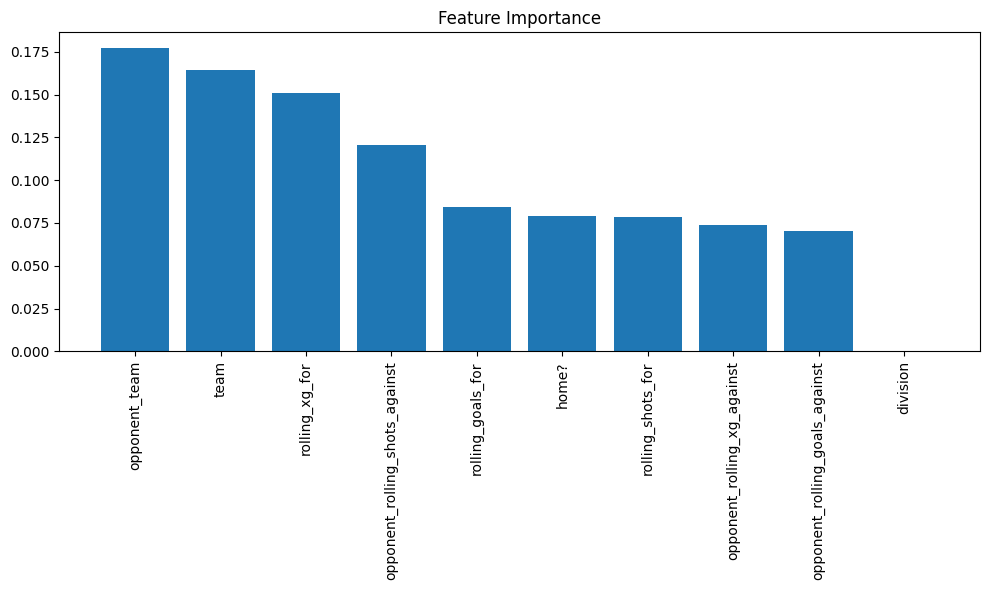

Feature importance ranking:
1. opponent_team: 0.1775
2. team: 0.1646
3. rolling_xg_for: 0.1508
4. opponent_rolling_shots_against: 0.1207
5. rolling_goals_for: 0.0842
6. home?: 0.0792
7. rolling_shots_for: 0.0787
8. opponent_rolling_xg_against: 0.0740
9. opponent_rolling_goals_against: 0.0705
10. division: 0.0000


In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model is your trained XGBoost model from GridSearchCV
# Get feature importance
importance = model.feature_importances_

# Get feature names (assuming your X_train is a pandas DataFrame)
# If not, you'll need to create a list of feature names
feature_names = X_train.columns

# Sort importance in descending order
indices = np.argsort(importance)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importance in descending order
print("Feature importance ranking:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]}: {importance[idx]:.4f}")

In [106]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.03, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}
# Create base model
xgb_model = xgb.XGBRegressor(
    random_state=26,
    enable_categorical=True  # Keep categorical feature support
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=4  # Use all available cores
)

# Fit grid search (assuming X_train and y_train are your features and target)
#grid_search.fit(X_train, y_train)

# Best parameters and score
#print("Best parameters:", grid_search.best_params_)
#print("Best CV score:", -grid_search.best_score_)  # Convert back from negative MSE

# Create model with best parameters
#best_model = grid_search.best_estimator_

In [107]:
# Reset index before splitting to avoid duplicate indices
X_with_reset_index = X.reset_index(drop=True)
y_with_reset_index = y.reset_index(drop=True)
final_df_reset = final_df.reset_index(drop=True)

# Now split using the reset data
X_train = X_with_reset_index[final_df_reset['match_date'] < feb_2025_cutoff]
y_train = y_with_reset_index[final_df_reset['match_date'] < feb_2025_cutoff]
X_test = X_with_reset_index[final_df_reset['match_date'] >= feb_2025_cutoff]
y_test = y_with_reset_index[final_df_reset['match_date'] >= feb_2025_cutoff]

# Train and predict as before
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Now creating the results DataFrame is simple
test_results = pd.DataFrame({
    'actual_goals': y_test,
    'predicted_goals': y_pred,
    'error': y_test - y_pred,
    'abs_error': abs(y_test - y_pred)
})

# Add match information - this will align correctly since indices are reset
test_results['match_date'] = final_df_reset.loc[y_test.index, 'match_date']
test_results['team'] = final_df_reset.loc[y_test.index, 'team']
test_results['opponent_team'] = final_df_reset.loc[y_test.index, 'opponent_team']
test_results['home'] = final_df_reset.loc[y_test.index, 'home?']
test_results['division'] = final_df_reset.loc[y_test.index, 'division']

# Sort by date
test_results = test_results.sort_values('match_date')

test_results[test_results["division"] == 'Premier League']

,actual_goals,predicted_goals,error,abs_error,match_date,team,opponent_team,home,division
735,0,1.611820,-1.611820,1.611820,2025-03-08,Man City,Nott'm Forest,0,Premier League
576,0,0.925023,-0.925023,0.925023,2025-03-08,Ipswich,Crystal Palace,0,Premier League
670,3,2.918859,0.081141,0.081141,2025-03-08,Liverpool,Southampton,1,Premier League
930,1,1.539369,-0.539369,0.539369,2025-03-08,Nott'm Forest,Man City,1,Premier League
1180,1,0.729180,0.270820,0.270820,2025-03-08,Southampton,Liverpool,0,Premier League
511,1,1.464738,-0.464738,0.464738,2025-03-08,Fulham,Brighton,0,Premier League
1449,1,1.241294,-0.241294,0.241294,2025-03-08,Wolves,Everton,1,Premier League
446,1,1.411716,-0.411716,0.411716,2025-03-08,Everton,Wolves,0,Premier League
56,1,1.506003,-0.506003,0.506003,2025-03-08,Aston Villa,Brentford,0,Premier League
381,1,1.904211,-0.904211,0.904211,2025-03-08,Crystal Palace,Ipswich,1,Premier League


In [108]:
def predict_match(trained_model, X_test, home_team, away_team, division="Premier League", match_date=None, debug=True):
    # Set match_date if not provided
    if match_date is None:
        match_date = datetime.now()
    elif isinstance(match_date, str):
        match_date = pd.to_datetime(match_date)
    
    # Calculate metrics using calc_team_metrics_up_to_date function for both teams
    home_metrics = calc_team_metrics_up_to_date(home_team, match_date)
    away_metrics = calc_team_metrics_up_to_date(away_team, match_date)
    
    # Create prediction features for home team
    home_features = pd.DataFrame({
        'division': [division],
        'home?': [1],
        'team': [home_team],
        'opponent_team': [away_team],
        'rolling_goals_for': [home_metrics['rolling_goals_for']],
        'rolling_xg_for': [home_metrics['rolling_xg_for']],
        'rolling_shots_for': [home_metrics['rolling_shots_for']],
        'opponent_rolling_goals_against': [away_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [away_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [away_metrics['rolling_shots_against']]
    })
    
    # Create prediction features for away team
    away_features = pd.DataFrame({
        'division': [division],
        'home?': [0],
        'team': [away_team],
        'opponent_team': [home_team],
        'rolling_goals_for': [away_metrics['rolling_goals_for']],
        'rolling_xg_for': [away_metrics['rolling_xg_for']],
        'rolling_shots_for': [away_metrics['rolling_shots_for']],
        'opponent_rolling_goals_against': [home_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [home_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [home_metrics['rolling_shots_against']]
    })
    
    # Apply the same categorical encoding from X_test
    for col in ["division", "team", "opponent_team"]:
        home_features[col] = pd.Categorical(
            home_features[col],
            categories=X_test[col].cat.categories,
            ordered=X_test[col].cat.ordered
        )
        away_features[col] = pd.Categorical(
            away_features[col],
            categories=X_test[col].cat.categories,
            ordered=X_test[col].cat.ordered
        )
    
    # Print features for debugging
    if debug:
        print("Home team features:")
        print(home_features)
        print("\nAway team features:")
        print(away_features)
    
    # Make predictions
    home_goals_pred = trained_model.predict(home_features)[0]
    away_goals_pred = trained_model.predict(away_features)[0]
    
    # Calculate win probabilities using Poisson distribution
    max_goals = 10
    home_goals_pmf = np.array([poisson.pmf(i, home_goals_pred) for i in range(max_goals)])
    away_goals_pmf = np.array([poisson.pmf(i, away_goals_pred) for i in range(max_goals)])
    
    # Create a matrix of probabilities for each score combination
    score_matrix = np.outer(home_goals_pmf, away_goals_pmf)
    
    # Calculate outcome probabilities
    home_win_prob = np.sum(np.tril(score_matrix, -1))  # Below diagonal (home > away)
    draw_prob = np.sum(np.diag(score_matrix))          # Diagonal (home = away)
    away_win_prob = np.sum(np.triu(score_matrix, 1))   # Above diagonal (home < away)
    
    # Find most likely scoreline
    max_score_idx = np.unravel_index(score_matrix.argmax(), score_matrix.shape)
    most_likely_score = f"{max_score_idx[0]}-{max_score_idx[1]}"
    
    # Return results
    return {
        'home_team': home_team,
        'away_team': away_team,
        'division': division,
        'match_date': match_date,
        'predicted_home_goals': round(home_goals_pred, 2),
        'predicted_away_goals': round(away_goals_pred, 2),
        'home_win_probability': round(home_win_prob * 100, 2),
        'draw_probability': round(draw_prob * 100, 2),
        'away_win_probability': round(away_win_prob * 100, 2),
        'most_likely_score': most_likely_score,
        'expected_total_goals': round(home_goals_pred + away_goals_pred, 2)
    }

In [120]:
# Example usage
prediction = predict_match(
    trained_model=model,  # Your trained XGBoost model
    X_test=X_test,        # Your test dataset (needed for categorical encodings)
    home_team="Southampton",
    away_team="Crystal Palace",
    division="Premier League",
    match_date="2025-03-17"  # Optional - defaults to current date if not provided
)

# Print the prediction results
print(prediction)

# To access specific values
print(f"Predicted score: {prediction['predicted_home_goals']:.2f} - {prediction['predicted_away_goals']:.2f}")
print(f"Most likely result: {prediction['most_likely_score']}")
print(f"Win probabilities: Home {prediction['home_win_probability']}%, Draw {prediction['draw_probability']}%, Away {prediction['away_win_probability']}%")

Home team features:
         division  home?         team   opponent_team  rolling_goals_for  \
0  Premier League      1  Southampton  Crystal Palace           0.883724   

   rolling_xg_for  rolling_shots_for  opponent_rolling_goals_against  \
0        1.178052          10.261082                        1.103208   

   opponent_rolling_xg_against  opponent_rolling_shots_against  
0                     1.435135                       12.242009  

Away team features:
         division  home?            team opponent_team  rolling_goals_for  \
0  Premier League      0  Crystal Palace   Southampton           1.538751   

   rolling_xg_for  rolling_shots_for  opponent_rolling_goals_against  \
0        1.852563          14.019899                        2.249262   

   opponent_rolling_xg_against  opponent_rolling_shots_against  
0                     2.503233                       16.913868  
{'home_team': 'Southampton', 'away_team': 'Crystal Palace', 'division': 'Premier League', 'match_date

In [110]:
def calculate_team_strength(trained_model, X_test, team, match_date=None, division="Premier League"):
    # Set match_date if not provided
    if match_date is None:
        match_date = datetime.now()
    elif isinstance(match_date, str):
        match_date = pd.to_datetime(match_date)
    
    # Calculate team metrics
    team_metrics = calc_team_metrics_up_to_date(team, match_date)
    
    # Calculate league average metrics automatically
    # Get all teams in the dataset
    all_teams = X_test['team'].cat.categories.tolist()
    
    # Calculate average metrics across all teams
    avg_metrics = {
        'rolling_goals_for': 0,
        'rolling_goals_against': 0,
        'rolling_xg_for': 0,
        'rolling_xg_against': 0,
        'rolling_shots_for': 0,
        'rolling_shots_against': 0
    }
    
    valid_team_count = 0
    for t in all_teams:
        try:
            t_metrics = calc_team_metrics_up_to_date(t, match_date)
            # Only include teams with valid metrics
            if not np.isnan(t_metrics['rolling_goals_for']):
                avg_metrics['rolling_goals_for'] += t_metrics['rolling_goals_for']
                avg_metrics['rolling_goals_against'] += t_metrics['rolling_goals_against']
                avg_metrics['rolling_xg_for'] += t_metrics['rolling_xg_for']
                avg_metrics['rolling_xg_against'] += t_metrics['rolling_xg_against']
                avg_metrics['rolling_shots_for'] += t_metrics['rolling_shots_for']
                avg_metrics['rolling_shots_against'] += t_metrics['rolling_shots_against']
                valid_team_count += 1
        except:
            continue
    
    # Calculate averages
    for key in avg_metrics:
        if valid_team_count > 0:
            avg_metrics[key] /= valid_team_count
    
    # Create features for team vs average (no home advantage)
    team_features = pd.DataFrame({
        'division': [division],
        'home?': [0],  # No home advantage
        'team': [team],
        'opponent_team': ['Average Team'],
        'rolling_goals_for': [team_metrics['rolling_goals_for']],
        'rolling_xg_for': [team_metrics['rolling_xg_for']],
        'rolling_shots_for': [team_metrics['rolling_shots_for']],
        'opponent_rolling_goals_against': [avg_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [avg_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [avg_metrics['rolling_shots_against']]
    })
    
    avg_features = pd.DataFrame({
        'division': [division],
        'home?': [0],  # No home advantage
        'team': ['Average Team'],
        'opponent_team': [team],
        'rolling_goals_for': [avg_metrics['rolling_goals_for']],
        'rolling_xg_for': [avg_metrics['rolling_xg_for']],
        'rolling_shots_for': [avg_metrics['rolling_shots_for']],
        'opponent_rolling_goals_against': [team_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [team_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [team_metrics['rolling_shots_against']]
    })
    
    # Handle categorical encoding
    for col in ["division", "team", "opponent_team"]:
        if col in ["team", "opponent_team"]:
            # We need to ensure 'Average Team' is in the categories
            if "Average Team" not in X_test[col].cat.categories:
                team_features[col] = pd.Categorical(
                    team_features[col],
                    categories=list(X_test[col].cat.categories) + ["Average Team"],
                    ordered=X_test[col].cat.ordered
                )
                avg_features[col] = pd.Categorical(
                    avg_features[col],
                    categories=list(X_test[col].cat.categories) + ["Average Team"],
                    ordered=X_test[col].cat.ordered
                )
            else:
                team_features[col] = pd.Categorical(
                    team_features[col],
                    categories=X_test[col].cat.categories,
                    ordered=X_test[col].cat.ordered
                )
                avg_features[col] = pd.Categorical(
                    avg_features[col],
                    categories=X_test[col].cat.categories,
                    ordered=X_test[col].cat.ordered
                )
        else:
            team_features[col] = pd.Categorical(
                team_features[col],
                categories=X_test[col].cat.categories,
                ordered=X_test[col].cat.ordered
            )
            avg_features[col] = pd.Categorical(
                avg_features[col],
                categories=X_test[col].cat.categories,
                ordered=X_test[col].cat.ordered
            )
    
    # Make predictions
    team_goals_pred = trained_model.predict(team_features)[0]
    avg_goals_pred = trained_model.predict(avg_features)[0]
    
    # Goal difference against average team
    goal_diff = team_goals_pred - avg_goals_pred
    
    return {
        'team': team,
        'predicted_goals_for': round(team_goals_pred, 2),
        'predicted_goals_against': round(avg_goals_pred, 2),
        'predicted_goal_diff': round(goal_diff, 2)
    }

def generate_team_strength_table(trained_model, X_test, final_df, match_date=None, division="Premier League"):
    # Filter teams that are in the specified division in final_df
    premier_league_teams = final_df[final_df['division'] == division]['team'].unique().tolist()
    
    # Calculate strength for each team
    team_strengths = []
    for team in premier_league_teams:
        try:
            # Skip teams that aren't in X_test categories
            if team not in X_test['team'].cat.categories:
                continue
                
            strength = calculate_team_strength(
                trained_model=trained_model,
                X_test=X_test,
                team=team,
                match_date=match_date,
                division=division
            )
            team_strengths.append(strength)
        except Exception as e:
            print(f"Error calculating strength for {team}: {e}")
            continue
    
    # Create DataFrame from results
    strength_df = pd.DataFrame(team_strengths)
    
    # Sort by predicted goal difference (descending)
    strength_df = strength_df.sort_values('predicted_goal_diff', ascending=False)
    
    # Add rank column
    strength_df['rank'] = range(1, len(strength_df) + 1)
    
    # Reorder columns
    strength_df = strength_df[['rank', 'team', 'predicted_goals_for', 'predicted_goals_against', 
                              'predicted_goal_diff']]
    
    return strength_df

# Example usage
def print_strength_table(trained_model, X_test, date=None):
    strength_table = generate_team_strength_table(
        trained_model=trained_model,
        final_df=final_df,
        X_test=X_test,
        match_date=date
    )
    
    print(f"===== Team Strength Table (as of {date if date else 'today'}) =====")
    print("(All values calculated against league average opponent with no home advantage)")
    print(strength_table.to_string(index=False))
    
    return strength_table

# Example call
strength_table = print_strength_table(model, X_test, date="2025-03-17")

===== Team Strength Table (as of 2025-03-17) =====
(All values calculated against league average opponent with no home advantage)
 rank           team  predicted_goals_for  predicted_goals_against  predicted_goal_diff
    1      Liverpool                 2.37                     1.24                 1.13
    2        Arsenal                 2.10                     1.20                 0.90
    3        Chelsea                 2.40                     1.58                 0.83
    4       Man City                 2.30                     1.60                 0.70
    5  Nott'm Forest                 2.11                     1.49                 0.62
    6      Newcastle                 2.22                     1.65                 0.57
    7      Tottenham                 2.26                     1.78                 0.48
    8    Bournemouth                 1.84                     1.42                 0.41
    9      Brentford                 2.36                     1.97            